In [1]:
import sys
import logging
import multiprocessing as mp

import pymc as pm
import pymc.sampling_jax as pmjax
import pandas as pd
import numpy as np
import arviz as az
import pytensor.tensor as pt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.preprocessing import StandardScaler,LabelBinarizer
import pickle
import numpyro
# from google.colab import drive

In [2]:
# Set working directory
path = '/Users/wenyuzeng/Downloads/bayesian-bioassay-main/data/Tox21/'

In [3]:
# X_train = pd.read_csv(path + 'X_train_resampled_80_20.csv')
# y_train = pd.read_csv(path + 'y_train_resampled_80_20.csv')
# X_test = pd.read_csv(path + 'X_test_80_20.csv')
# y_test = pd.read_csv(path + 'y_test_80_20.csv')
two_assay = pd.read_csv(path + 'two-assay-example.csv')

In [4]:
two_assay.PROTOCOL_NAME.value_counts()

tox21-ar-mda-kb2-luc-antagonist-p1    9670
tox21-ar-mda-kb2-luc-agonist-p3       8829
Name: PROTOCOL_NAME, dtype: int64

In [5]:
assay1 = two_assay[two_assay['PROTOCOL_NAME'] == 'tox21-ar-mda-kb2-luc-antagonist-p1']
assay2 = two_assay[two_assay['PROTOCOL_NAME'] == 'tox21-ar-mda-kb2-luc-agonist-p3']

In [6]:
CHANNEL_OUTCOME_factor = pd.factorize(assay1.CHANNEL_OUTCOME)
assay1['CHANNEL_OUTCOME'] = CHANNEL_OUTCOME_factor[0]
assay1
CHANNEL_OUTCOME_factor = pd.factorize(assay2.CHANNEL_OUTCOME)
assay2['CHANNEL_OUTCOME'] = CHANNEL_OUTCOME_factor[0]
assay2

/var/folders/q3/4xkzknpn01j0stqqmhhm0jpr0000gn/T/ipykernel_21606/1005760544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assay1['CHANNEL_OUTCOME'] = CHANNEL_OUTCOME_factor[0]
/var/folders/q3/4xkzknpn01j0stqqmhhm0jpr0000gn/T/ipykernel_21606/1005760544.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assay2['CHANNEL_OUTCOME'] = CHANNEL_OUTCOME_factor[0]


,PROTOCOL_NAME,CHANNEL_OUTCOME,SAMPLE_NAME,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,tox21-ar-mda-kb2-luc-agonist-p3,0,Imipenem,11.938415,-1.104254,11.938415,0.052549,0.224452,299.352,282.216,...,1,0,0,0,0,0,0,0,2,0
1,tox21-ar-mda-kb2-luc-agonist-p3,0,Quinapril hydrochloride,13.260918,-1.036043,13.260918,0.000000,0.542299,474.985,443.737,...,0,0,0,0,0,0,0,0,0,0
2,tox21-ar-mda-kb2-luc-agonist-p3,0,Diphenoxylate hydrochloride,13.076853,-0.710688,13.076853,0.000000,0.369982,489.059,455.795,...,0,0,0,0,0,0,0,0,0,0
3,tox21-ar-mda-kb2-luc-agonist-p3,0,Eperisone hydrochloride,12.391306,0.000000,12.391306,0.000000,0.766044,295.854,269.646,...,0,0,0,0,0,0,0,0,0,0
4,tox21-ar-mda-kb2-luc-agonist-p3,0,Pranoprofen,11.024948,-0.820607,11.024948,0.513338,0.764395,255.273,242.169,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824,tox21-ar-mda-kb2-luc-agonist-p3,0,Allyl carbamate,9.710417,-0.763981,9.710417,0.189815,0.507294,101.105,94.049,...,0,0,0,0,0,0,0,0,0,0
8825,tox21-ar-mda-kb2-luc-agonist-p3,0,Digoxigenin,12.126902,-0.906229,12.126902,0.001289,0.599240,390.520,356.248,...,0,0,0,0,0,0,0,0,0,0
8826,tox21-ar-mda-kb2-luc-agonist-p3,0,4-(2-Chloroethyl)morpholine hydrochloride (1:1),5.552379,0.000000,5.552379,0.000000,0.595762,186.082,172.978,...,0,0,0,0,0,0,0,0,0,0
8827,tox21-ar-mda-kb2-luc-agonist-p3,0,4-(Diethylamino)benzaldehyde,10.413113,0.732320,10.413113,0.732320,0.657837,177.247,162.127,...,0,0,0,0,0,0,0,0,0,0


In [7]:
assay1_X_train = assay1.iloc[:, 3:6]
assay1_X_train
assay1_y_train = assay1.CHANNEL_OUTCOME
assay1_y_train.value_counts()

0    8884
1     786
Name: CHANNEL_OUTCOME, dtype: int64

In [8]:
assay2_X_train = assay2.iloc[:, 3:6]
assay2_X_train
assay2_y_train = assay2.CHANNEL_OUTCOME
assay2_y_train.value_counts()

0    7845
1     984
Name: CHANNEL_OUTCOME, dtype: int64

In [9]:
assays_X_train = []
assays_y_train = []
assays_X_train.append(assay1_X_train)
assays_X_train.append(assay2_X_train)
assays_y_train.append(assay1_y_train)
assays_y_train.append(assay2_y_train)

In [10]:
assay_list=[]
assay_list.append(assay1)
assay_list.append(assay2)

In [11]:
np.array(assay1_X_train).shape

(9670, 3)

In [15]:
coords_simulateds = []
X_trains = []
for i in [0, 1]:
    ss = StandardScaler()
    X_train = ss.fit_transform(assays_X_train[i])
    factorized_protocols = pd.factorize(assay_list[i].PROTOCOL_NAME)
    coords_simulated = {
        'obs_id': np.arange(X_train.shape[0]),
        'chem_descrip': np.arange(X_train.shape[1]),
        'protocol':list(factorized_protocols[1]),
        'params':['beta_{0}'.format(j) for j in range(X_train.shape[1])]
        }
    coords_simulateds.append(coords_simulated)
    X_trains.append(X_train)

In [16]:
print('start model setup')
assays_level_model = []
for j in range(2):

    X4_bayes = np.asarray(X_trains[j], dtype="float64")
    Y4_bayes = list(assays_y_train[j])
    factorized_protocols = pd.factorize(assay_list[j].PROTOCOL_NAME)
    
    with pm.Model(coords=coords_simulateds[j]) as assay_level_model:
        x = pm.Data('x', X4_bayes, mutable = True)
        protocol_idx = pm.Data("protocol_idx", list(factorized_protocols[0]), mutable=True)
        y = pm.Data('y', Y4_bayes, mutable=True)

        sd_dist = pm.Exponential.dist(1.0)

            # get back standard deviations and rho:
        chol, corr, stds = pm.LKJCholeskyCov("chol", n=X4_bayes.shape[1], eta=2.0, sd_dist=sd_dist, compute_corr=True)

            #hyperpriors and priors for average betas:
        beta_list = []
        for i in range(X4_bayes.shape[1]):
            gbeta = pm.Normal("g_beta_{0}".format(i), mu=0.0, sigma=10.0, shape=1)
            mu_gbeta = gbeta[0]
            sigma_beta = pm.Exponential('sigma_beta_{0}'.format(i), 1.0)
            betas = pm.Normal('beta_{0}'.format(i), mu=mu_gbeta,sigma=sigma_beta,dims="protocol")
            beta_list.append(betas)

            #population of varying protocol effects:
        beta_protocol = pm.MvNormal("beta_protocol", mu=pt.stack(beta_list, axis=1), chol=chol,dims=('protocol', 'params'))

            #Expected value per protocol:
        theta = beta_protocol[protocol_idx,0]* x[:,0]

        for i in range(1,X4_bayes.shape[1]):
            theta += beta_protocol[protocol_idx,i] * x[:,i]

        p = 1.0 / (1.0 + pt.exp(-theta))
        likelihood = pm.Bernoulli('likelihood', p, observed=y, shape = p.shape)
        
    assays_level_model.append(assay_level_model)


print('Done model setup')



start model setup
Done model setup


In [17]:
assays_level_model

[         chol ~ _lkjcholeskycov(3, 2, Exponential(f()))
      g_beta_0 ~ Normal(0, 10)
  sigma_beta_0 ~ Exponential(f())
        beta_0 ~ Normal(f(g_beta_0), sigma_beta_0)
      g_beta_1 ~ Normal(0, 10)
  sigma_beta_1 ~ Exponential(f())
        beta_1 ~ Normal(f(g_beta_1), sigma_beta_1)
      g_beta_2 ~ Normal(0, 10)
  sigma_beta_2 ~ Exponential(f())
        beta_2 ~ Normal(f(g_beta_2), sigma_beta_2)
 beta_protocol ~ MultivariateNormal(f(beta_2, beta_1, beta_0, chol), f(chol))
     chol_corr ~ Deterministic(f(chol))
     chol_stds ~ Deterministic(f(chol))
    likelihood ~ Bernoulli(f(beta_protocol)),
          chol ~ _lkjcholeskycov(3, 2, Exponential(f()))
      g_beta_0 ~ Normal(0, 10)
  sigma_beta_0 ~ Exponential(f())
        beta_0 ~ Normal(f(g_beta_0), sigma_beta_0)
      g_beta_1 ~ Normal(0, 10)
  sigma_beta_1 ~ Exponential(f())
        beta_1 ~ Normal(f(g_beta_1), sigma_beta_1)
      g_beta_2 ~ Normal(0, 10)
  sigma_beta_2 ~ Exponential(f())
        beta_2 ~ Normal(f(g_beta_2), 

In [18]:
for i in range(2):
    with assays_level_model[i]:
        tr_assay = pmjax.sample_numpyro_nuts(draws=1000, tune=1000, chains=4)
print('Finish training model')

Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [0 1 1 2 2 2], [0 0 1 0 1 2])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [0 1 1 2 2 2], [0 0 1 0 1 2])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    return self.fn(fgraph, node)
  File "/User

Compilation time =  0:00:04.652988
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [0 1 1 2 2 2], [0 0 1 0 1 2])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [0 1 1 2 2 2], [0 0 1 0 1 2])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    return self.fn(fgraph, node)
  File "/User

Sampling time =  0:07:13.805390
Transforming variables...
Transformation time =  0:00:00.311319
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [0 1 1 2 2 2], [0 0 1 0 1 2])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [0 1 1 2 2 2], [0 0 1 0 1 2])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    return self.fn(fgraph, node)
  File "/User

Compilation time =  0:00:02.876505
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [0 1 1 2 2 2], [0 0 1 0 1 2])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [0 1 1 2 2 2], [0 0 1 0 1 2])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    return self.fn(fgraph, node)
  File "/User

Sampling time =  0:06:18.828111
Transforming variables...
Transformation time =  0:00:00.062942
Finish training model


In [20]:
tr_assay

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [21]:
with assay_level_model:
    tr_assay.extend(pm.sample_posterior_predictive(tr_assay))

Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


In [22]:
tr_assay

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [28]:
pd.DataFrame(az.summary(tr_assay, kind="stats"))

,mean,sd,hdi_3%,hdi_97%
g_beta_0[0],-1.221,2.722,-6.363,4.092
beta_0[tox21-ar-mda-kb2-luc-agonist-p3],-1.249,2.333,-5.515,3.322
g_beta_1[0],-0.172,1.857,-3.802,3.617
beta_1[tox21-ar-mda-kb2-luc-agonist-p3],-0.131,1.275,-2.960,2.212
g_beta_2[0],1.194,2.630,-3.583,6.305
beta_2[tox21-ar-mda-kb2-luc-agonist-p3],1.221,2.347,-3.059,5.952
"beta_protocol[tox21-ar-mda-kb2-luc-agonist-p3, beta_0]",-1.226,2.010,-4.987,2.538
"beta_protocol[tox21-ar-mda-kb2-luc-agonist-p3, beta_1]",-0.103,0.026,-0.150,-0.054
"beta_protocol[tox21-ar-mda-kb2-luc-agonist-p3, beta_2]",1.230,2.013,-2.548,4.994
chol[0],1.024,0.985,0.012,2.810


In [19]:
with assay_level_model:
    pm.set_data(
        new_data = {'x': X_test,
                    "protocol_idx": list(protocol_pred[0]),
                    "y": outcomes_out_of_sample
                   }
    )
    posterior_predictive = pm.sample_posterior_predictive(
        tr_assay, var_names=["likelihood"],
        predictions = True
    )

NameError: name 'X_test' is not defined

### Hierarchical Model with chemical descriptor and gender

In [3]:
path = '/Users/wenyuzeng/Downloads/'
xls = pd.ExcelFile(path + 'assay_list.xls')
df = []
for i in range(len(xls.sheet_names)):
    df1 = xls.parse(i)
    df.append(df1)

len(df)

22

In [4]:
xls2 = pd.ExcelFile(path + 'assay_list2.xls')

for i in range(len(xls2.sheet_names)):
    df1 = xls2.parse(i)
    df.append(df1)

len(df)

50

In [5]:
feature_top_40 = ['fr_C_O', 'TPSA', 'SMR_VSA1', 'NumHAcceptors', 'NumAromaticCarbocycles','NumHeteroatoms',
                  'Chi4n', 'VSA_EState10', 'VSA_EState3', 'Kappa1', 'Chi2v', 'SMR_VSA10', 'SlogP_VSA2',
                  'HallKierAlpha', 'SMR_VSA5', 'VSA_EState7', 'FractionCSP3', 'SlogP_VSA10', 'BCUT2D_LOGPLOW',
                  'VSA_EState2', 'FpDensityMorgan2', 'fr_phenol_noOrthoHbond', 'SlogP_VSA1', 'PEOE_VSA1',
                  'fr_Ar_N', 'BCUT2D_CHGLO', 'fr_ether', 'EState_VSA1', 'MinPartialCharge', 'VSA_EState6',
                  'MaxPartialCharge', 'MinAbsPartialCharge', 'VSA_EState9', 'SMR_VSA3', 'FpDensityMorgan3',
                  'SlogP_VSA12', 'fr_Al_OH_noTert', 'BalabanJ', 'MaxAbsPartialCharge', 'EState_VSA10']
from sklearn import preprocessing, metrics
from imblearn.under_sampling import RandomUnderSampler, NearMiss

In [6]:
label_encoder = preprocessing.LabelEncoder()
# Training
bal_accs_t = []
auc_scores_t = []
recalls_t = []
f1s_t = []
precisions_t = []

# Validation
bal_accs_v = []
auc_scores_v = []
recalls_v = []
f1s_v = []
precisions_v = []

# Testing
bal_accs = []
auc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []

# Others
assays_level_model = []
tr_coefficients = []

for z in [0, 1, 2, 3, 4]:
    for w in range(len(df)):
        scaler = StandardScaler()
        one_assay = df[w]
        one_assay = one_assay.drop(one_assay.columns[0],axis=1).drop_duplicates(subset = 'SMILES')
        y = label_encoder.fit_transform(one_assay.iloc[:,0])
        X = one_assay[one_assay.columns.intersection(feature_top_40)]

        X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state = 42)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.25, 
                                                              shuffle=True, random_state = z)# 5 CV on training

        near_miss = RandomUnderSampler(random_state = z) 
        X_train_resampled, y_train_resampled = near_miss.fit_resample(X_train, y_train)# undersampling

        X_train = scaler.fit_transform(X_train_resampled)
        X_valid = scaler.transform(X_valid)
        X_valid = np.array(X_valid)
        X_test = scaler.transform(X_test)
        X_test = np.array(X_test)


        factorized_protocols = pd.factorize([one_assay.columns[2]] * X_train.shape[0])

        coords_simulated = {
            'obs_id': np.arange(X_train.shape[0]),
            'chem_descrip': np.arange(X_train.shape[1]),
            'protocol':list(factorized_protocols[1]),
            'params':['beta_{0}'.format(j) for j in range(X_train.shape[1])]
            }

        X4_bayes = np.asarray(X_train, dtype="float64")
        Y4_bayes = list(y_train_resampled)

        with pm.Model(coords=coords_simulated) as assay_level_model:
            x = pm.Data('x', X4_bayes, mutable = True)
            protocol_idx = pm.Data("protocol_idx", list(factorized_protocols[0]), mutable=True)
            y = pm.Data('y', Y4_bayes, mutable=True)

            sd_dist = pm.Exponential.dist(1.0)

                # get back standard deviations and rho:
            chol, corr, stds = pm.LKJCholeskyCov("chol", n=X4_bayes.shape[1], eta=2.0, sd_dist=sd_dist, compute_corr=True)

                #hyperpriors and priors for average betas:
            beta_list = []
            for i in range(X4_bayes.shape[1]):
                gbeta = pm.Normal("g_beta_{0}".format(i), mu=0.0, sigma=10.0, shape=1)
                mu_gbeta = gbeta[0]
                sigma_beta = pm.Exponential('sigma_beta_{0}'.format(i), 1.0)
                betas = pm.Normal('beta_{0}'.format(i), mu=mu_gbeta,sigma=sigma_beta,dims="protocol")
                beta_list.append(betas)

                #population of varying protocol effects:
            beta_protocol = pm.MvNormal("beta_protocol", mu=pt.stack(beta_list, axis=1), chol=chol,dims=('protocol', 'params'))

                #Expected value per protocol:
            theta = beta_protocol[protocol_idx,0]* x[:,0]

            for i in range(1,X4_bayes.shape[1]):
                theta += beta_protocol[protocol_idx,i] * x[:,i]

            p = 1.0 / (1.0 + pt.exp(-theta))
            likelihood = pm.Bernoulli('likelihood', p, observed=y, shape = p.shape)

        assays_level_model.append(assay_level_model)

        with assay_level_model:
            tr_assay = pmjax.sample_numpyro_nuts(draws=1000, tune=1000, chains=4)

        coef = pd.DataFrame(az.summary(tr_assay, kind="stats"))
        tr_coefficients.append(coef)
        
        # Model Performance
        #Training
        with assay_level_model:
            tr_assay.extend(pm.sample_posterior_predictive(tr_assay))

        train_pred = pd.DataFrame(tr_assay.posterior_predictive['likelihood'].mean(('chain', 'draw')), columns = ['prob'])
        train_pred['round'] = train_pred.prob.round()

        bal_acc_t = metrics.balanced_accuracy_score(list(y_train_resampled), list(train_pred['round']))
        auc_score_t = metrics.roc_auc_score(list(y_train_resampled), list(train_pred['prob']))                               
        recall_t = metrics.recall_score(y_train_resampled, list(train_pred['round']))
        f1_t = metrics.f1_score(y_train_resampled, list(train_pred['round']))
        precision_t = metrics.precision_score(y_train_resampled, list(train_pred['round']))

        bal_accs_t.append(bal_acc_t)
        auc_scores_t.append(auc_score_t)
        recalls_t.append(recall_t)
        f1s_t.append(f1_t)
        precisions_t.append(precision_t)

        #Generate Testing data
        protocol_pred = pd.factorize([one_assay.columns[2]] * X_test.shape[0])

        with assay_level_model:
            pm.set_data(
                new_data = {'x': X_test,
                            "protocol_idx": list(protocol_pred[0]),
                            "y": y_test
                           }
            )
            posterior_predictive = pm.sample_posterior_predictive(
                tr_assay, var_names=["likelihood"],
                predictions = True
            )

        #Testing Performance
        y_pred = pd.DataFrame(posterior_predictive.predictions['likelihood'].mean(('chain', 'draw')),columns=['prob'])
        y_pred['round'] = y_pred.prob.round()

        bal_acc = metrics.balanced_accuracy_score(list(y_test), list(y_pred['round']))
        auc_roc = metrics.roc_auc_score(list(y_test), y_pred['prob'])
        recall = metrics.recall_score(list(y_test), list(y_pred['round']))
        f1 = metrics.f1_score(list(y_test), list(y_pred['round']))
        precision = metrics.precision_score(list(y_test), list(y_pred['round']))

        bal_accs.append(bal_acc)
        auc_scores.append(auc_roc)
        f1_scores.append(f1)
        recall_scores.append(recall)
        precision_scores.append(precision)

        #Generate Validation data
        protocol_valid = pd.factorize([one_assay.columns[2]] * X_valid.shape[0])

        with assay_level_model:
            pm.set_data(
                new_data = {'x': X_valid,
                            "protocol_idx": list(protocol_valid[0]),
                            "y": y_valid
                           }
            )
            posterior_valid = pm.sample_posterior_predictive(
                tr_assay, var_names=["likelihood"],
                predictions = True
            )

        #Validation
        y_pred_v = pd.DataFrame(posterior_valid.predictions['likelihood'].mean(('chain', 'draw')),columns=['prob'])
        y_pred_v['round'] = y_pred_v.prob.round()

        bal_acc_v = metrics.balanced_accuracy_score(list(y_valid), list(y_pred_v['round']))
        auc_roc_v = metrics.roc_auc_score(list(y_valid), y_pred_v['prob'])
        recall_v = metrics.recall_score(list(y_valid), list(y_pred_v['round']))
        f1_v = metrics.f1_score(list(y_valid), list(y_pred_v['round']))
        precision_v = metrics.precision_score(list(y_valid), list(y_pred_v['round']))

        bal_accs_v.append(bal_acc_v)
        auc_scores_v.append(auc_roc_v)
        recalls_v.append(recall_v)
        f1s_v.append(f1_v)
        precisions_v.append(precision_v)

        print(w)


Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:22.789783
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:53.500044
Transforming variables...
Transformation time =  0:00:00.555634


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


0
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:21.873306
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:30.560938
Transforming variables...
Transformation time =  0:00:00.251874


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


1
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:22.550885
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:56.354731
Transforming variables...
Transformation time =  0:00:00.272536


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


2
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:21.384144
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:01.533118
Transforming variables...
Transformation time =  0:00:00.233594


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


3
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:21.641992
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:44.263232
Transforming variables...
Transformation time =  0:00:00.204798


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


4
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:22.055924
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:39.575733
Transforming variables...
Transformation time =  0:00:00.236095


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


5
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:20.776226
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:53.119784
Transforming variables...
Transformation time =  0:00:00.235167


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


6
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:22.305884
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:35.099844
Transforming variables...
Transformation time =  0:00:00.200128


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


7
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:22.877491
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:24.411770
Transforming variables...
Transformation time =  0:00:00.229458


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


8
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:21.687776
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:19.174768
Transforming variables...
Transformation time =  0:00:00.290414


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


9
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:21.272281
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:59.547141
Transforming variables...
Transformation time =  0:00:00.254906


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


10
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:21.900655
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:26.594950
Transforming variables...
Transformation time =  0:00:00.226346


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


11
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:21.822709
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:39.138190
Transforming variables...
Transformation time =  0:00:00.230600


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


12
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:21.916941
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:25.255108
Transforming variables...
Transformation time =  0:00:00.256117


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


13
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:20.036768
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:34.116490
Transforming variables...
Transformation time =  0:00:00.253714


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


14
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:22.713192
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:50.911823
Transforming variables...
Transformation time =  0:00:00.274804


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


15
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:22.713793
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:40.887022
Transforming variables...
Transformation time =  0:00:00.229971


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


16
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:20.277982
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:12:27.810432
Transforming variables...
Transformation time =  0:00:00.236231


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


17
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:23.510470
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:47.328563
Transforming variables...
Transformation time =  0:00:00.260836


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


18
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:23.663320
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:16.782145
Transforming variables...
Transformation time =  0:00:00.244663


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


19
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:20.589530
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:38.859292
Transforming variables...
Transformation time =  0:00:00.252733


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


20
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:21.979775
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:16:33.790021
Transforming variables...
Transformation time =  0:00:00.276969


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


21
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:21.504874
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:59.163230
Transforming variables...
Transformation time =  0:00:00.254065


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


22
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:22.149054
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:28.296533
Transforming variables...
Transformation time =  0:00:00.261365


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


23
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:21.852449
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:04:04.560105
Transforming variables...
Transformation time =  0:00:00.242830


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


24
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:22.102056
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:59.519040
Transforming variables...
Transformation time =  0:00:00.248130


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


25
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:21.279026
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:01.091300
Transforming variables...
Transformation time =  0:00:00.264964


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


26
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:22.043346
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:28.933390
Transforming variables...
Transformation time =  0:00:00.233118


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


27
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:22.453766
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:05:32.353789
Transforming variables...
Transformation time =  0:00:00.269866


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


28
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:21.706138
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:01.606224
Transforming variables...
Transformation time =  0:00:00.278304


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


29
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:22.764195
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:18.823266
Transforming variables...
Transformation time =  0:00:00.251524


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


30
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:22.684049
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:47.754477
Transforming variables...
Transformation time =  0:00:00.248015


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


31
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:23.041713
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:56.617570
Transforming variables...
Transformation time =  0:00:00.261711


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


32
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:23.099670
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:52.684381
Transforming variables...
Transformation time =  0:00:00.244074


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


33
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:23.189801
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:35.745540
Transforming variables...
Transformation time =  0:00:00.269906


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


34
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:23.958707
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:11.253815
Transforming variables...
Transformation time =  0:00:00.329540


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


35
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:24.702892
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:35.139961
Transforming variables...
Transformation time =  0:00:00.328281


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


36
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:25.105690
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:20.792315
Transforming variables...
Transformation time =  0:00:00.329539


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


37
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:23.521972
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:47.498573
Transforming variables...
Transformation time =  0:00:00.336250


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


38
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.057955
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:05:31.518033
Transforming variables...
Transformation time =  0:00:00.267710


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


39
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:24.086678
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:05:09.550101
Transforming variables...
Transformation time =  0:00:00.275695


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


40
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:25.577012
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:28.784108
Transforming variables...
Transformation time =  0:00:00.329800


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


41
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:25.761276
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:39.138541
Transforming variables...
Transformation time =  0:00:00.324808


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


42
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:26.003404
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:59.790816
Transforming variables...
Transformation time =  0:00:00.317773


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


43
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:26.239745
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:06.431774
Transforming variables...
Transformation time =  0:00:00.295380


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


44
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.081441
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:24:35.899698
Transforming variables...
Transformation time =  0:00:00.328311


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


45
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.131299
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:27:42.135101
Transforming variables...
Transformation time =  0:00:00.336232


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


46
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.273863
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:24:29.050875
Transforming variables...
Transformation time =  0:00:00.294052


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


47
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.202966
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:55.467547
Transforming variables...
Transformation time =  0:00:00.283530


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


48
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.310053
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:15:37.934598
Transforming variables...
Transformation time =  0:00:00.326281


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


49
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.318576
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:47.446426
Transforming variables...
Transformation time =  0:00:00.277116


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


0
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.257212
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:05:56.228467
Transforming variables...
Transformation time =  0:00:00.290773


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


1
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:27.690514
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:16.761412
Transforming variables...
Transformation time =  0:00:00.295509


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


2
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:27.719117
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  1:09:32.932924
Transforming variables...
Transformation time =  0:00:00.333747


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


3
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:28.953038
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:57.710612
Transforming variables...
Transformation time =  0:00:00.244352


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


4
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:29.464739
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:49.929644
Transforming variables...
Transformation time =  0:00:00.288696


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


5
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:31.754754
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:09.641889
Transforming variables...
Transformation time =  0:00:00.257978


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


6
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.882830
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:12:32.324874
Transforming variables...
Transformation time =  0:00:00.314523


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


7
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.141430
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:30.570245
Transforming variables...
Transformation time =  0:00:00.325267


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


8
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:30.048245
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  1:10:49.415125
Transforming variables...
Transformation time =  0:00:00.344324


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


9
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:29.743447
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:32.931781
Transforming variables...
Transformation time =  0:00:00.303007


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


10
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:30.008981
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:09.172186
Transforming variables...
Transformation time =  0:00:00.294343


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


11
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.733474
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:41.268034
Transforming variables...
Transformation time =  0:00:00.273198


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


12
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.478391
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:42.538279
Transforming variables...
Transformation time =  0:00:00.279203


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


13
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:29.560482
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:27.461304
Transforming variables...
Transformation time =  0:00:00.306630


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


14
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:29.930827
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:22.878392
Transforming variables...
Transformation time =  0:00:00.294132


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


15
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.684953
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:49.463382
Transforming variables...
Transformation time =  0:00:00.333099


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


16
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.450449
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  1:50:28.805376
Transforming variables...
Transformation time =  0:00:00.348264


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


17
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:29.891378
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:51.269219
Transforming variables...
Transformation time =  0:00:00.302552


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


18
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.492289
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:48.943626
Transforming variables...
Transformation time =  0:00:00.313966


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


19
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.285061
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:00.088328
Transforming variables...
Transformation time =  0:00:00.299112


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


20
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:30.278934
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:17:17.234690
Transforming variables...
Transformation time =  0:00:00.299336


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


21
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.509367
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:30.950592
Transforming variables...
Transformation time =  0:00:00.229146


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


22
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.283502
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:01.018875
Transforming variables...
Transformation time =  0:00:00.283555


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


23
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:30.804924
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:03:58.164226
Transforming variables...
Transformation time =  0:00:00.366153


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


24
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.566893
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:04.340760
Transforming variables...
Transformation time =  0:00:00.256504


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


25
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:31.803894
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:38.518205
Transforming variables...
Transformation time =  0:00:00.273625


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


26
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.170501
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:04.281796
Transforming variables...
Transformation time =  0:00:00.342241


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


27
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.465418
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:39.238877
Transforming variables...
Transformation time =  0:00:00.267753


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


28
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:32.461570
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:07.999178
Transforming variables...
Transformation time =  0:00:00.370957


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


29
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.427299
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:12:43.544709
Transforming variables...
Transformation time =  0:00:00.294353


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


30
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:32.343050
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:06.226436
Transforming variables...
Transformation time =  0:00:00.326754


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


31
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.856207
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:17.055652
Transforming variables...
Transformation time =  0:00:00.339173


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


32
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:34.299221
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:35.756691
Transforming variables...
Transformation time =  0:00:00.318240


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


33
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.685507
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:57.628873
Transforming variables...
Transformation time =  0:00:00.366429


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


34
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.629147
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:53.264205
Transforming variables...
Transformation time =  0:00:00.328572


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


35
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.144735
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:30.108719
Transforming variables...
Transformation time =  0:00:00.275799


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


36
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.454819
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:20.557948
Transforming variables...
Transformation time =  0:00:00.299997


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


37
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.167031
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:32.031956
Transforming variables...
Transformation time =  0:00:00.285021


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


38
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.331620
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:05:38.617067
Transforming variables...
Transformation time =  0:00:00.267691


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


39
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.331764
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:05:16.285550
Transforming variables...
Transformation time =  0:00:00.273825


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


40
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.347115
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:18.920073
Transforming variables...
Transformation time =  0:00:00.340711


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


41
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.195683
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:12:13.427919
Transforming variables...
Transformation time =  0:00:00.339616


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


42
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.979648
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:45.475097
Transforming variables...
Transformation time =  0:00:00.347990


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


43
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.186210
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:03.675636
Transforming variables...
Transformation time =  0:00:00.332091


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


44
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.455833
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:26:40.288462
Transforming variables...
Transformation time =  0:00:00.258709


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


45
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.323010
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:24:07.006244
Transforming variables...
Transformation time =  0:00:00.299549


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


46
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.570518
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:27:34.918395
Transforming variables...
Transformation time =  0:00:00.368007


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


47
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.322370
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:13.837441
Transforming variables...
Transformation time =  0:00:00.267702


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


48
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:41.199457
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:14:30.963557
Transforming variables...
Transformation time =  0:00:00.343333


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


49
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.726217
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:14.566057
Transforming variables...
Transformation time =  0:00:00.295800


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


0
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:36.940676
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:46.341377
Transforming variables...
Transformation time =  0:00:00.327416


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


1
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.470573
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:40.591510
Transforming variables...
Transformation time =  0:00:00.289519


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


2
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.136763
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:51.809138
Transforming variables...
Transformation time =  0:00:00.375566


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


3
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.799081
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:24.570981
Transforming variables...
Transformation time =  0:00:00.283688


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


4
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.377434
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:22.106238
Transforming variables...
Transformation time =  0:00:00.283252


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


5
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:38.502102
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:24.476160
Transforming variables...
Transformation time =  0:00:00.302735


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


6
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.483496
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:12:06.540858
Transforming variables...
Transformation time =  0:00:00.271149


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


7
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:44.794521
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:31.828513
Transforming variables...
Transformation time =  0:00:00.310481


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


8
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.826844
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:20.158773
Transforming variables...
Transformation time =  0:00:00.296819


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


9
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.426199
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:55.528234
Transforming variables...
Transformation time =  0:00:00.306345


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


10
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:46.600644
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:12.756625
Transforming variables...
Transformation time =  0:00:00.335833


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


11
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.648234
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:34.796429
Transforming variables...
Transformation time =  0:00:00.355098


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


12
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:46.943417
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:19.759302
Transforming variables...
Transformation time =  0:00:00.332493


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


13
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.765535
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:31.239371
Transforming variables...
Transformation time =  0:00:00.322579


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


14
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.395104
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:13.075992
Transforming variables...
Transformation time =  0:00:00.304109


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


15
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:47.994206
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:37.623796
Transforming variables...
Transformation time =  0:00:00.306154


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


16
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.679777
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:12:57.430576
Transforming variables...
Transformation time =  0:00:00.306369


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


17
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.474657
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:56.632693
Transforming variables...
Transformation time =  0:00:00.290889


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


18
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:49.138261
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:23.213231
Transforming variables...
Transformation time =  0:00:00.308299


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


19
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.695682
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:46.251070
Transforming variables...
Transformation time =  0:00:00.321349


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


20
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.302204
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:18:26.493437
Transforming variables...
Transformation time =  0:00:00.316031


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


21
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.696393
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:15.308323
Transforming variables...
Transformation time =  0:00:00.326322


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


22
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.525164
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:58.862898
Transforming variables...
Transformation time =  0:00:00.327805


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


23
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.386980
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:04:26.094638
Transforming variables...
Transformation time =  0:00:00.295634


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


24
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.742880
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:18.792338
Transforming variables...
Transformation time =  0:00:00.300412


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


25
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.614232
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:25.450840
Transforming variables...
Transformation time =  0:00:00.312358


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


26
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.579116
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:01.351034
Transforming variables...
Transformation time =  0:00:00.298845


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


27
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.725845
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:18.166633
Transforming variables...
Transformation time =  0:00:00.319962


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


28
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.603399
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:05.111117
Transforming variables...
Transformation time =  0:00:00.402260


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


29
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.472863
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:13:08.564094
Transforming variables...
Transformation time =  0:00:00.343733


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


30
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.850750
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:27.798154
Transforming variables...
Transformation time =  0:00:00.340043


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


31
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.663822
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:11.038188
Transforming variables...
Transformation time =  0:00:00.288603


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


32
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.359161
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:50.652942
Transforming variables...
Transformation time =  0:00:00.337400


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


33
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:54.222520
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:27.050126
Transforming variables...
Transformation time =  0:00:00.402458


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


34
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.881293
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:54.482899
Transforming variables...
Transformation time =  0:00:00.310990


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


35
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.371912
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:44.062527
Transforming variables...
Transformation time =  0:00:00.298223


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


36
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:55.302212
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:50.837516
Transforming variables...
Transformation time =  0:00:00.323067


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


37
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.067733
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:06.763980
Transforming variables...
Transformation time =  0:00:00.331783


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


38
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.568159
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:05:05.646237
Transforming variables...
Transformation time =  0:00:00.354124


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


39
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:56.684980
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:04:54.380339
Transforming variables...
Transformation time =  0:00:00.356367


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


40
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.760668
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:28.889914
Transforming variables...
Transformation time =  0:00:00.328026


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


41
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.834020
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:29.103258
Transforming variables...
Transformation time =  0:00:00.361450


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


42
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.616092
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:13.899759
Transforming variables...
Transformation time =  0:00:00.359521


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


43
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:57.316557
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:38.607595
Transforming variables...
Transformation time =  0:00:00.352038


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


44
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.142394
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:22:20.801430
Transforming variables...
Transformation time =  0:00:00.360469


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


45
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.666787
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:26:15.876682
Transforming variables...
Transformation time =  0:00:00.346356


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


46
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.569389
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:27:49.202053
Transforming variables...
Transformation time =  0:00:00.344632


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


47
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.864410
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:48.419158
Transforming variables...
Transformation time =  0:00:00.424076


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


48
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.782668
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:13:42.000727
Transforming variables...
Transformation time =  0:00:00.374117


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


49
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.678770
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:14.493401
Transforming variables...
Transformation time =  0:00:00.342190


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


0
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:01:01.186889
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:12.890259
Transforming variables...
Transformation time =  0:00:00.355844


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


1
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.055791
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:37.569754
Transforming variables...
Transformation time =  0:00:00.340565


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


2
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.912910
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:22.138616
Transforming variables...
Transformation time =  0:00:00.358284


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


3
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.765720
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:15.586710
Transforming variables...
Transformation time =  0:00:00.332847


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


4
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:01:01.191101
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:32.236773
Transforming variables...
Transformation time =  0:00:00.347970


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


5
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.905954
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:30.576414
Transforming variables...
Transformation time =  0:00:00.357850


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


6
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.730037
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:38.961956
Transforming variables...
Transformation time =  0:00:00.381281


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


7
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.711611
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:01.584013
Transforming variables...
Transformation time =  0:00:00.386516


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


8
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:01:06.128216
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:12.898602
Transforming variables...
Transformation time =  0:00:00.344626


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


9
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.069314
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:56.828416
Transforming variables...
Transformation time =  0:00:00.309043


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


10
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.626593
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:04.884580
Transforming variables...
Transformation time =  0:00:00.308839


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


11
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.695342
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:00.033781
Transforming variables...
Transformation time =  0:00:00.356187


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


12
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:01:06.128478
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:36.744802
Transforming variables...
Transformation time =  0:00:00.355894


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


13
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.159922
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:39.426845
Transforming variables...
Transformation time =  0:00:00.382898


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


14
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.046510
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:09.549154
Transforming variables...
Transformation time =  0:00:00.369926


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


15
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.867781
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:02.249897
Transforming variables...
Transformation time =  0:00:00.312058


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


16
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:01:06.878974
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:38.453658
Transforming variables...
Transformation time =  0:00:00.308384


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


17
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.079484
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:50.526954
Transforming variables...
Transformation time =  0:00:00.308918


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


18
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.952558
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:44.544066
Transforming variables...
Transformation time =  0:00:00.328540


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


19
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.794032
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:01.314096
Transforming variables...
Transformation time =  0:00:00.315592


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


20
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.906816
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:17:42.743584
Transforming variables...
Transformation time =  0:00:00.335279


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


21
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.009436
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:46.408838
Transforming variables...
Transformation time =  0:00:00.299395


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


22
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:20.380447
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:41.661437
Transforming variables...
Transformation time =  0:00:00.313755


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


23
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.327772
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:04:10.533942
Transforming variables...
Transformation time =  0:00:00.311747


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


24
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.218819
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:25.026999
Transforming variables...
Transformation time =  0:00:00.343837


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


25
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:01:25.532453
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:11.068117
Transforming variables...
Transformation time =  0:00:00.391386


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


26
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.655320
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:05:20.984398
Transforming variables...
Transformation time =  0:00:00.337373


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


27
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.580542
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:26.691741
Transforming variables...
Transformation time =  0:00:00.294953


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


28
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.613435
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:08.277952
Transforming variables...
Transformation time =  0:00:00.328492


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


29
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.324645
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:12:13.567633
Transforming variables...
Transformation time =  0:00:00.330069


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


30
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:01:29.025636
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:54.955516
Transforming variables...
Transformation time =  0:00:00.335350


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


31
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.495160
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:13.089861
Transforming variables...
Transformation time =  0:00:00.358333


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


32
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.569661
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:11.012041
Transforming variables...
Transformation time =  0:00:00.320903


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


33
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.237367
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:31.019479
Transforming variables...
Transformation time =  0:00:00.313528


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


34
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.678243
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:03.205053
Transforming variables...
Transformation time =  0:00:00.356856


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


35
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.650494
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:36.500106
Transforming variables...
Transformation time =  0:00:00.340686


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


36
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.935745
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:31.361300
Transforming variables...
Transformation time =  0:00:00.322967


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


37
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.596603
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:12:09.918825
Transforming variables...
Transformation time =  0:00:00.398860


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


38
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.356365
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:05:25.545119
Transforming variables...
Transformation time =  0:00:00.323602


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


39
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.261473
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:05:10.356265
Transforming variables...
Transformation time =  0:00:00.376111


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


40
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:01:39.459781
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:25.181853
Transforming variables...
Transformation time =  0:00:00.363877


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


41
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.629584
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:13:02.256342
Transforming variables...
Transformation time =  0:00:00.329269


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


42
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.714395
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:40.847419
Transforming variables...
Transformation time =  0:00:00.358403


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


43
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.986086
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:11.223378
Transforming variables...
Transformation time =  0:00:00.350881


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


44
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.678456
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  2:02:06.689816
Transforming variables...
Transformation time =  0:00:00.359464


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


45
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:01:37.707961
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:46:45.549258
Transforming variables...
Transformation time =  0:00:00.322025


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


46
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.122300
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:25:26.058898
Transforming variables...
Transformation time =  0:00:00.337132


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


47
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.066757
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:29.196910
Transforming variables...
Transformation time =  0:00:00.314631


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


48
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.001936
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:15:39.237266
Transforming variables...
Transformation time =  0:00:00.297699


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


49
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.876192
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  1:50:33.238248
Transforming variables...
Transformation time =  0:00:00.421127


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


0
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:01:42.092025
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:48.532872
Transforming variables...
Transformation time =  0:00:00.403981


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


1
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.223049
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:07.694995
Transforming variables...
Transformation time =  0:00:00.372923


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


2
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.240256
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:18:05.075259
Transforming variables...
Transformation time =  0:00:00.351427


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


3
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.154264
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:19.073030
Transforming variables...
Transformation time =  0:00:00.368876


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


4
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.851057
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:50.046134
Transforming variables...
Transformation time =  0:00:00.343097


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


5
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.706149
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:27.726258
Transforming variables...
Transformation time =  0:00:00.374351


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


6
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:01:44.676327
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:28.568011
Transforming variables...
Transformation time =  0:00:00.302903


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


7
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.643884
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:53.710735
Transforming variables...
Transformation time =  0:00:00.334426


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


8
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.351809
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:41.710217
Transforming variables...
Transformation time =  0:00:00.325469


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


9
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.113690
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:56.750215
Transforming variables...
Transformation time =  0:00:00.328262


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


10
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.150250
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:45.742733
Transforming variables...
Transformation time =  0:00:00.351318


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


11
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.933075
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:30.536810
Transforming variables...
Transformation time =  0:00:00.293470


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


12
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.347597
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:20.795880
Transforming variables...
Transformation time =  0:00:00.417262


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


13
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.242296
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:22.832329
Transforming variables...
Transformation time =  0:00:00.328003


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


14
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.357274
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:09:56.295631
Transforming variables...
Transformation time =  0:00:00.389267


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


15
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.974736
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:16.792640
Transforming variables...
Transformation time =  0:00:00.371883


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


16
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.626202
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:12:03.182073
Transforming variables...
Transformation time =  0:00:00.341693


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


17
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.813467
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:47.008264
Transforming variables...
Transformation time =  0:00:00.376571


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


18
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.130400
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:01.006133
Transforming variables...
Transformation time =  0:00:00.402520


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


19
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.053270
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:22.878133
Transforming variables...
Transformation time =  0:00:00.298779


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


20
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.146488
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:17:33.003188
Transforming variables...
Transformation time =  0:00:00.386821


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


21
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.124369
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:03.999401
Transforming variables...
Transformation time =  0:00:00.366485


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


22
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.904172
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:52.164668
Transforming variables...
Transformation time =  0:00:00.310812


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


23
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.589676
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:04:01.601552
Transforming variables...
Transformation time =  0:00:00.376530


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


24
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:01:55.940559
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:44.515245
Transforming variables...
Transformation time =  0:00:00.405542


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


25
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.938333
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:07:11.071688
Transforming variables...
Transformation time =  0:00:00.305397


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


26
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.166109
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:26.013115
Transforming variables...
Transformation time =  0:00:00.347651


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


27
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.913453
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:18.460483
Transforming variables...
Transformation time =  0:00:00.403666


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


28
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.090905
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:12.072830
Transforming variables...
Transformation time =  0:00:00.355477


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


29
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.803492
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:12:10.712770
Transforming variables...
Transformation time =  0:00:00.381771


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


30
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.788083
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:12:27.352347
Transforming variables...
Transformation time =  0:00:00.336173


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


31
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.327984
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:26.415784
Transforming variables...
Transformation time =  0:00:00.331986


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


32
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.260099
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:10.872248
Transforming variables...
Transformation time =  0:00:00.429081


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


33
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.236492
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:30.422246
Transforming variables...
Transformation time =  0:00:00.353316


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


34
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.018474
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:05.468155
Transforming variables...
Transformation time =  0:00:00.308763


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


35
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.895572
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:14.216160
Transforming variables...
Transformation time =  0:00:00.433084


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


36
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.862199
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:30.920735
Transforming variables...
Transformation time =  0:00:00.306035


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


37
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:01:57.121254
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:26.885332
Transforming variables...
Transformation time =  0:00:00.320248


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


38
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.978582
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:05:08.813208
Transforming variables...
Transformation time =  0:00:00.298220


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


39
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.260375
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:05:03.839748
Transforming variables...
Transformation time =  0:00:00.366586


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


40
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:18.981836
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:11:32.618329
Transforming variables...
Transformation time =  0:00:00.383004


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


41
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.082378
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:55.526886
Transforming variables...
Transformation time =  0:00:00.357681


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


42
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.063099
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:10:29.810475
Transforming variables...
Transformation time =  0:00:00.390916


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


43
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.141123
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:08:54.244305
Transforming variables...
Transformation time =  0:00:00.339369


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


44
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:02:09.389245
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:24:38.796881
Transforming variables...
Transformation time =  0:00:00.325069


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


45
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.232605
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:28:06.095995
Transforming variables...
Transformation time =  0:00:00.344114


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


46
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.331111
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:26:23.433834
Transforming variables...
Transformation time =  0:00:00.350734


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


47
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.248532
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:06:40.561931
Transforming variables...
Transformation time =  0:00:00.337245


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


48
Compiling...


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Compilation time =  0:00:19.165321
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR:pytensor.graph.rewriting.basic:node: AdvancedSetSubtensor(Alloc.0, AdvancedIncSubtensor1{no_inplace,set}.0, [ 0  1  1 ... 39 39 39], [ 0  0  1 ... 37 38 39])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    re

Sampling time =  0:15:27.943429
Transforming variables...
Transformation time =  0:00:00.314143


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


49


In [19]:
#Training Performance
print(np.mean(bal_accs_t))
print(np.std(bal_accs_t))

print(np.mean(auc_scores_t))
print(np.std(auc_scores_t))

print(np.mean(recalls_t))
print(np.std(recalls_t))

print(np.mean(f1s_t))
print(np.std(f1s_t))

print(np.mean(precisions_t))
print(np.std(precisions_t))

0.7827817303780257
0.033910407328371917
0.8619205995518965
0.031041540652050753
0.7560331782779767
0.04091336647772714
0.7766589693061912
0.03520119797635241
0.7992360919543025
0.0367672485372728


In [20]:
# Validation
print(np.mean(bal_accs_v))
print(np.std(bal_accs_v))

print(np.mean(auc_scores_v))
print(np.std(auc_scores_v))

print(np.mean(recalls_v))
print(np.std(recalls_v))

print(np.mean(f1s_v))
print(np.std(f1s_v))

print(np.mean(precisions_v))
print(np.std(precisions_v))

0.7442540184551014
0.025559082979773592
0.8186044702445066
0.024492653987221134
0.7164539696816841
0.051604815972346375
0.3553288673089145
0.11668804286568457
0.2473345492839526
0.112600345220573


In [21]:
# Testing
print(np.mean(bal_accs))
print(np.std(bal_accs))

print(np.mean(auc_scores))
print(np.std(auc_scores))

print(np.mean(recall_scores))
print(np.std(recall_scores))

print(np.mean(f1_scores))
print(np.std(f1_scores))

print(np.mean(precision_scores))
print(np.std(precision_scores))

0.7418240244496254
0.029168719367696157
0.8154304998485066
0.02783421161606911
0.7142738343135223
0.05593657045750056
0.3523304663702198
0.11647243425229442
0.24441328914217123
0.1126095965183425


In [124]:
#Training Performance random_state = 1
print(np.mean(bal_accs_t))
print(np.mean(auc_scores_t))
print(np.mean(recalls_t))
print(np.mean(f1s_t))
print(np.mean(precisions_t))

0.7808079114929698
0.8597781766199808
0.7548321875114337
0.7748685547894196
0.7966546487474759


In [125]:
#validation Performance random_state = 1
print(np.mean(bal_accs_v))
print(np.mean(auc_scores_v))
print(np.mean(recalls_v))
print(np.mean(f1s_v))
print(np.mean(precisions_v))

0.7431401317035025
0.8173110001089731
0.7144829110295149
0.35085756539244634
0.24395983492648202


In [126]:
# testing performance random_state = 1
print(np.mean(bal_accs))
print(np.mean(auc_scores))
print(np.mean(recall_scores))
print(np.mean(f1_scores))
print(np.mean(precision_scores))

0.7432464007070092
0.8140077875118678
0.7154068544338847
0.3535850699433453
0.24556561026784166


In [128]:
#Training Performance random_state = 2
print(np.mean(bal_accs_t))
print(np.mean(auc_scores_t))
print(np.mean(recalls_t))
print(np.mean(f1s_t))
print(np.mean(precisions_t))

0.7789358304925915
0.8601082883552635
0.7514694970984388
0.7726799339229448
0.7961393365741888


In [129]:
#validation Performance random_state = 2
print(np.mean(bal_accs_v))
print(np.mean(auc_scores_v))
print(np.mean(recalls_v))
print(np.mean(f1s_v))
print(np.mean(precisions_v))

0.7467548924302245
0.8198309685177781
0.723023296238982
0.3570528498451757
0.248151565000507


In [130]:
# testing performance random_state = 2
print(np.mean(bal_accs))
print(np.mean(auc_scores))
print(np.mean(recall_scores))
print(np.mean(f1_scores))
print(np.mean(precision_scores))

0.7379910306844601
0.8133110018194987
0.7080183528428071
0.3502560751135207
0.24316787857481814


In [134]:
#Training Performance random_state = 3 & 4
print(np.mean(bal_accs_t))
print(np.std(bal_accs_t))
print(np.mean(auc_scores_t))
print(np.std(auc_scores_t))
print(np.mean(recalls_t))
print(np.std(recalls_t))
print(np.mean(f1s_t))
print(np.std(f1s_t))
print(np.mean(precisions_t))
print(np.std(precisions_t))

0.7842678421248066
0.03742330861442838
0.8632281174012293
0.03214409786789346
0.7568906321171889
0.044578048801376495
0.7779978219520184
0.03892230822518345
0.8010345478394876
0.03896082797618412


In [135]:
#validation Performance random_state = 3&4
print(np.mean(bal_accs_v))
print(np.std(bal_accs_v))

print(np.mean(auc_scores_v))
print(np.std(auc_scores_v))

print(np.mean(recalls_v))
print(np.std(recalls_v))

print(np.mean(f1s_v))
print(np.std(f1s_v))

print(np.mean(precisions_v))
print(np.std(precisions_v))

0.742272698501599
0.025010345119795854
0.817773470042706
0.023184792952351933
0.7112845124783136
0.0495289558985296
0.3557357748071449
0.1174088973731243
0.24835900286643423
0.11417585531445222


In [136]:
# testing performance random_state = 3&4
print(np.mean(bal_accs))
print(np.std(bal_accs))

print(np.mean(auc_scores))
print(np.std(auc_scores))

print(np.mean(recall_scores))
print(np.std(recall_scores))

print(np.mean(f1_scores))
print(np.std(f1_scores))

print(np.mean(precision_scores))
print(np.std(precision_scores))

0.7423865228621929
0.028589348608183785
0.8165554578717465
0.02787077692598854
0.7141956787053673
0.05693361873352968
0.3526786646980775
0.1159438812571435
0.24487673553291756
0.11313455611766138


In [138]:
#Training Performance random_state = 0,1,2
print(np.mean(bal_accs_t))
print(np.std(bal_accs_t))
print(np.mean(auc_scores_t))
print(np.std(auc_scores_t))
print(np.mean(recalls_t))
print(np.std(recalls_t))
print(np.mean(f1s_t))
print(np.std(f1s_t))
print(np.mean(precisions_t))
print(np.std(precisions_t))

0.7813887620580899
0.029840207115503628
0.8611557913778131
0.03048568089782783
0.7539745893783596
0.036046395899145794
0.7751471844944634
0.03091485857620867
0.798417567316325
0.03531032723071626


In [139]:
#validation Performance random_state = 0,1,2
print(np.mean(bal_accs_v))
print(np.std(bal_accs_v))

print(np.mean(auc_scores_v))
print(np.std(auc_scores_v))

print(np.mean(recalls_v))
print(np.std(recalls_v))

print(np.mean(f1s_v))
print(np.std(f1s_v))

print(np.mean(precisions_v))
print(np.std(precisions_v))

0.7451469569866214
0.026561962463078247
0.81908515765268
0.025414678862961643
0.7184870653629482
0.05422526894330226
0.35488012929949586
0.11663035380795951
0.246697211472854
0.11206738290371385


In [140]:
# testing performance random_state = 0,1,2
print(np.mean(bal_accs))
print(np.std(bal_accs))

print(np.mean(auc_scores))
print(np.std(auc_scores))

print(np.mean(recall_scores))
print(np.std(recall_scores))

print(np.mean(f1_scores))
print(np.std(f1_scores))

print(np.mean(precision_scores))
print(np.std(precision_scores))

0.7404950838961422
0.029389460481334905
0.8144192840209127
0.027774854514655573
0.7116714132941323
0.05527669440798703
0.3515936960343274
0.1173025156153998
0.24406901422106975
0.11317673330044738


In [7]:
## Coefficients

In [45]:
tr_coefficients[0].iloc[::2,:].iloc[:40,:]
coef = []
for i in range(len(tr_coefficients)):
    coe = tr_coefficients[i].iloc[::2,:].iloc[:40,:]
    coef.append(coe)

In [51]:
pd.concat(coef, axis=1).to_csv("coef_hierarchical.csv", index=False)

In [127]:
tr_coefficients[0].iloc[:80,:]

,mean,sd,hdi_3%,hdi_97%
g_beta_0[0],4.419,4.891,-5.033,12.988
beta_0[MaxEStateIndex],4.473,4.721,-5.220,12.411
g_beta_1[0],-2.546,3.658,-9.287,3.802
beta_1[MaxEStateIndex],-2.583,3.414,-9.145,3.605
g_beta_2[0],-3.879,4.439,-11.364,5.344
...,...,...,...,...
beta_37[MaxEStateIndex],-1.479,0.914,-3.383,0.241
g_beta_38[0],0.515,1.866,-3.575,4.008
beta_38[MaxEStateIndex],0.523,1.479,-2.418,3.773
g_beta_39[0],0.354,1.973,-3.321,4.574


In [119]:
h_c = pd.concat(coef, axis=1).iloc[:,::4]
std_val = np.std(h_c, axis=1)
h_c = abs(h_c)
h_c['features'] = feature_top_40
h_c['mean_val'] = np.mean(h_c.iloc[:,:-1],axis=1)
h_c['std_val'] = np.std(h_c.iloc[:,:-2], axis=1)
h_c
# std_val

,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,features,mean_val,std_val
g_beta_0[0],4.419,6.513,12.139,4.327,0.125,6.305,7.430,6.004,6.612,8.091,...,2.482,5.529,5.846,1.895,6.126,3.055,9.060,fr_C_O,5.683060,2.693891
g_beta_1[0],2.546,4.523,6.911,2.671,0.054,5.124,4.277,3.617,3.447,4.656,...,1.381,3.440,3.921,1.033,3.555,2.015,5.673,TPSA,3.426960,1.631525
g_beta_2[0],3.879,6.656,11.309,4.196,0.101,6.801,6.252,5.699,5.683,8.125,...,2.148,5.107,5.788,1.723,5.669,2.657,8.677,SMR_VSA1,5.148180,2.482882
g_beta_3[0],2.919,3.836,6.197,2.589,0.020,4.005,4.207,3.479,3.826,4.474,...,2.922,3.118,3.979,1.180,3.597,2.413,4.660,NumHAcceptors,3.267924,1.525898
g_beta_4[0],0.174,2.399,0.123,0.729,1.234,0.482,0.770,0.375,0.254,0.136,...,0.123,1.156,0.228,0.584,0.223,0.041,0.194,NumAromaticCarbocycles,0.836028,1.663454
g_beta_5[0],0.037,1.972,0.028,0.780,1.045,0.009,0.077,0.838,0.489,0.447,...,0.553,0.894,0.501,0.420,0.216,1.137,0.314,NumHeteroatoms,0.711384,1.223001
g_beta_6[0],0.357,0.381,0.045,0.003,0.779,0.274,0.534,0.456,1.073,0.759,...,1.010,0.717,0.686,0.199,0.067,1.366,0.172,Chi4n,0.492648,0.470082
g_beta_7[0],0.682,1.143,0.582,0.607,0.917,0.035,1.083,0.918,0.914,0.909,...,0.391,1.165,0.653,0.340,0.198,1.817,0.330,VSA_EState10,0.730764,0.571474
g_beta_8[0],0.220,0.254,0.230,1.129,0.253,0.512,0.373,0.225,0.551,0.373,...,0.393,0.022,0.491,0.127,0.160,0.416,0.221,VSA_EState3,0.339628,0.406180
g_beta_9[0],0.736,0.880,0.708,0.722,0.544,0.565,1.092,0.950,1.549,0.618,...,0.956,0.625,0.504,0.227,0.045,1.149,0.704,Kappa1,1.247212,2.542564


In [120]:
h_coe = h_c.sort_values(by=['mean_val'], ascending=True).iloc[:,-3:]
categories = []
for i in h_coe.features:
    if i.startswith('fr_'):
        categories.append('Fraction of a substructure')
    elif i.startswith('PEOE'):
        categories.append('MOE type - Partial Charges')
    elif i.startswith('SlogP'):
        categories.append('MOE type - LogP')
    elif i.startswith('SMR'):
        categories.append('MOE type - MR')
    elif i.startswith('EState') or i.startswith('VSA'):
        categories.append('MOE type - EState')
    elif i.startswith('BCUT2D'):
        categories.append('BCUT type')
    else:
        categories.append('physicochemical properties')
h_coe['category'] = categories
h_coe

,features,mean_val,std_val,category
g_beta_8[0],VSA_EState3,0.339628,0.406180,MOE type - EState
g_beta_35[0],SlogP_VSA12,0.389772,0.497235,MOE type - LogP
g_beta_38[0],MaxAbsPartialCharge,0.417404,0.455141,physicochemical properties
g_beta_23[0],PEOE_VSA1,0.422784,0.803655,MOE type - Partial Charges
g_beta_30[0],MaxPartialCharge,0.422896,0.509771,physicochemical properties
g_beta_28[0],MinPartialCharge,0.449924,0.613851,physicochemical properties
g_beta_6[0],Chi4n,0.492648,0.470082,physicochemical properties
g_beta_36[0],fr_Al_OH_noTert,0.509232,0.435148,Fraction of a substructure
g_beta_25[0],BCUT2D_CHGLO,0.511608,0.334383,BCUT type
g_beta_29[0],VSA_EState6,0.519328,0.543374,MOE type - EState


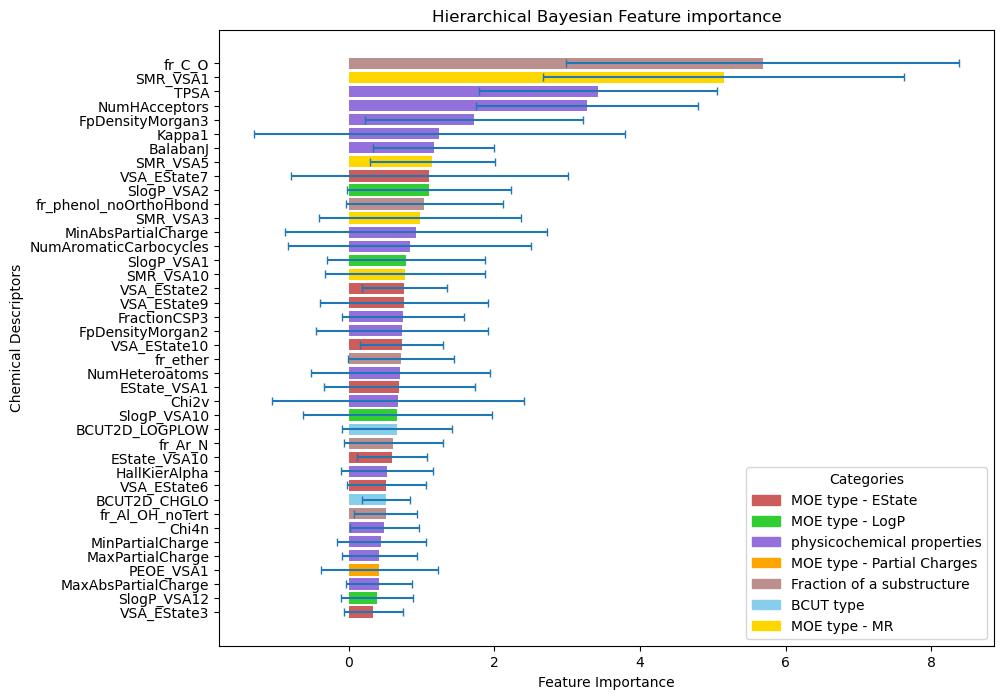

In [121]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 8))
colors = {'MOE type - EState': 'indianred', 'Fraction of a substructure': 'rosybrown', 'MOE type - LogP': 'limegreen',
          'MOE type - MR':'gold', 'MOE type - Partial Charges': 'orange',
          'physicochemical properties': 'mediumpurple', 'BCUT type': 'skyblue'}
plt.barh(data = h_coe, y='features', width='mean_val', color=[colors[i] for i in h_coe.category])
plt.errorbar(data = h_coe, y='features', x='mean_val', xerr = 'std_val', fmt ='none', capsize=3)

labels = h_coe['category'].unique()
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in labels]
plt.legend(handles, labels, title="Categories")
plt.title('Hierarchical Bayesian Feature importance')
plt.xlabel('Feature Importance')
plt.ylabel('Chemical Descriptors')
# plt.savefig(path + 'lgfi_new.png', dpi=1200, bbox_inches='tight')
plt.show()

In [138]:
ridge_rank = pd.read_csv('/Users/wenyuzeng/Downloads/ridge_feature_ranking.csv').sort_values(by='mean', ascending=False)
ridge_rank['rank'] = range(1, 41)
ridge_rank = ridge_rank[['Features', "rank"]]
ridge_rank = ridge_rank.rename(columns = {'Features': 'features'})

In [137]:
h_coe_rank = h_coe.copy(deep=True)
h_coe_rank = h_coe_rank.sort_values(by='mean_val', ascending=False)
h_coe_rank['rank_hoe'] = range(1,41)
h_coe_rank

,features,mean_val,std_val,category,rank_hoe
g_beta_0[0],fr_C_O,5.683060,2.693891,Fraction of a substructure,1
g_beta_2[0],SMR_VSA1,5.148180,2.482882,MOE type - MR,2
g_beta_1[0],TPSA,3.426960,1.631525,physicochemical properties,3
g_beta_3[0],NumHAcceptors,3.267924,1.525898,physicochemical properties,4
g_beta_34[0],FpDensityMorgan3,1.719572,1.493908,physicochemical properties,5
g_beta_9[0],Kappa1,1.247212,2.542564,physicochemical properties,6
g_beta_37[0],BalabanJ,1.165596,0.832520,physicochemical properties,7
g_beta_14[0],SMR_VSA5,1.149972,0.856221,MOE type - MR,8
g_beta_15[0],VSA_EState7,1.106408,1.903466,MOE type - EState,9
g_beta_12[0],SlogP_VSA2,1.105260,1.121851,MOE type - LogP,10


In [139]:
rank_df = pd.merge(ridge_rank, h_coe_rank, on="features")
rank_df

,features,rank,mean_val,std_val,category,rank_hoe
0,fr_C_O,1,5.683060,2.693891,Fraction of a substructure,1
1,SMR_VSA1,2,5.148180,2.482882,MOE type - MR,2
2,TPSA,3,3.426960,1.631525,physicochemical properties,3
3,NumHAcceptors,4,3.267924,1.525898,physicochemical properties,4
4,FpDensityMorgan3,5,1.719572,1.493908,physicochemical properties,5
5,BalabanJ,6,1.165596,0.832520,physicochemical properties,7
6,Kappa1,7,1.247212,2.542564,physicochemical properties,6
7,SlogP_VSA2,8,1.105260,1.121851,MOE type - LogP,10
8,SMR_VSA5,9,1.149972,0.856221,MOE type - MR,8
9,fr_phenol_noOrthoHbond,10,1.036216,1.076657,Fraction of a substructure,11


In [144]:
import scipy.stats as stats
tau, p_value = stats.kendalltau(rank_df['rank'], rank_df.rank_hoe)
print(tau)
print(p_value)

0.8564102564102565
7.088565634279374e-15
